<a href="https://colab.research.google.com/github/kcwanglucky/BertSequenceClassification_streamline/blob/master/0331_%E7%8E%89%E5%B1%B1%E5%B0%8F_i_%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/kcwanglucky/BertSequenceClassification_streamline.git

Cloning into 'BertSequenceClassification_streamline'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 117 (delta 71), reused 43 (delta 22), pack-reused 0
Receiving objects: 100% (117/117), 59.09 KiB | 332.00 KiB/s, done.
Resolving deltas: 100% (71/71), done.


In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 1.4MB/s 
     |████████████████████████████████| 870kB 3.1MB/s 
     |████████████████████████████████| 1.0MB 6.3MB/s 
     |████████████████████████████████| 3.7MB 8.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=a7d9dbe7dc92bdad0fbe95d67ecdaa37c695bee4749b925c95aba8c2280c072b
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from BertSequenceClassification_streamline.bert_downstream_classification import *
from BertSequenceClassification_streamline.app_comment import *

In [0]:
def let_colab_print_chinese():
    """Download the required font to print chinese characters on plots created by matplotlib
    Returns:
        FontProperties: when provide it as an argument to plt.plot graphs,
                        chinese character can be displayed
    """
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
    !unzip "NotoSansCJKkr-hinted.zip"
    !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/
    path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
    fontprop = fm.FontProperties(fname=path, size= 18)
    return fontprop

In [0]:
# 為了讓 colab 能 print 中文
fontprop = let_colab_print_chinese()
#fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 12)

--2020-04-06 14:26:23--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   157MB/s    in 0.7s    

2020-04-06 14:26:24 (157 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thin

In [0]:
"""set the arguments if not using a command line """
class Args:
    data_path = 'intent_reduced.csv'
    epoch = 60
    batch_size = 64
    min_each_group = 0                      # 每組至少要有幾筆才被放入訓練集
    maxlength = 60                          # 若app comment評論超過此長度則刪除
    model_output = 'model_ep60_eg0_ml50'
args = Args()

In [0]:
path = "intent.csv"
df = pd.read_csv(path)

In [0]:
df_new, NUM_LABELS = preprocessing(df, args.min_each_group, args.maxlength)

label的數量：499


In [0]:
all_intent = AppCommentData(df_new, mode = "all")

In [0]:
len(all_intent.df['index'].value_counts())

499

In [0]:
#all_intent.plot_pie(fontprop)
#all_intent.get_index_dist(verbose = True)
num_labels = all_intent.get_num_index()
index2label = all_intent.get_index2label()
label2index = all_intent.get_label2index()

In [0]:
# 1. 隨機抽樣
# df_train, df_val, df_test = train_val_test_split(df_new, 0.7)
# 2. 定比例抽樣
df_train, df_val, df_test = output_split(df_new, 0.8)

PRETRAINED_MODEL_NAME = "bert-base-chinese"
# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

訓練樣本數： 3553
validation樣本數： 437
預測樣本數： 437


In [0]:
# investigate train set
app_train = AppCommentData(df_train, "train", tokenizer, 64)
app_train.reindex(label2index)

In [0]:
# investigate test set
app_val = AppCommentData(df_val, "val", tokenizer, 64)
app_val.reindex(label2index)
app_test = AppCommentData(df_test, "test", tokenizer, 64)
app_test.reindex(label2index)

In [0]:
print("train set size: ", len(app_train.df))
print("validate set size: ", len(app_val.df))
print("test set size: ", len(app_test.df))

train set size:  3553
validate set size:  437
test set size:  437


In [0]:
trainloader = app_train.get_dataloader()
valloader = app_val.get_dataloader()
testloader = app_test.get_dataloader()


In [0]:
model = train(trainloader, valloader, PRETRAINED_MODEL_NAME, num_labels, args.epoch)
save_model(args, args.model_output, model, tokenizer)

device: cuda:0

======== Epoch 1 / 60 ========
Training...
loss: 305.206, acc: 0.046

Running Validation...
  Accuracy: 0.06

======== Epoch 2 / 60 ========
Training...
loss: 291.423, acc: 0.060

Running Validation...
  Accuracy: 0.07

======== Epoch 3 / 60 ========
Training...
loss: 279.217, acc: 0.083

Running Validation...
  Accuracy: 0.09

======== Epoch 4 / 60 ========
Training...
loss: 267.617, acc: 0.130

Running Validation...
  Accuracy: 0.11

======== Epoch 5 / 60 ========
Training...
loss: 256.632, acc: 0.195

Running Validation...
  Accuracy: 0.14

======== Epoch 6 / 60 ========
Training...
loss: 246.345, acc: 0.252

Running Validation...
  Accuracy: 0.17

======== Epoch 7 / 60 ========
Training...
loss: 237.052, acc: 0.309

Running Validation...
  Accuracy: 0.21

======== Epoch 8 / 60 ========
Training...
loss: 228.291, acc: 0.390

Running Validation...
  Accuracy: 0.25

======== Epoch 9 / 60 ========
Training...
loss: 219.651, acc: 0.411

Running Validation...
  Accuracy: 

In [0]:
# testing
predictions = get_predictions(model, testloader).detach().cpu().numpy()

true_label = app_test.df_reindex["index"]
class_matrix, false_group = get_confusion_matrix(true_label, predictions, num_labels)
print_acc(class_matrix)

Accuracy: 71.57894736842105%


In [0]:
counts = df_new['index'].value_counts().values

fontprop = fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 18)

In [0]:
def plot_dist_class(counts, bins):
    plt.figure(figsize=(14, 7), facecolor="w")
    plt.hist(counts, bins=bins, histtype='bar')
    plt.xlabel("筆數/類", fontproperties=fontprop)
    plt.ylabel("個數", fontproperties=fontprop)

    plt.axvline(counts.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    #plt.text(counts.mean() * 1.1, max_ylim*0.5, '平均: {:.2f}筆/組'.format(counts.mean()),  fontproperties=fontprop)

    # plt.axvline(5, color='r', linestyle='-', linewidth=1)
    # plt.text(5 * 1.1, max_ylim*0.9, '少於5筆的共有{}類'.format(sum(counts < 5)),  fontproperties=fontprop, color = 'r')
    

In [0]:
len(counts)

499

In [0]:
counts = df_new['index'].value_counts().values
fontprop = fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 22)
fontprop1 = fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 15)

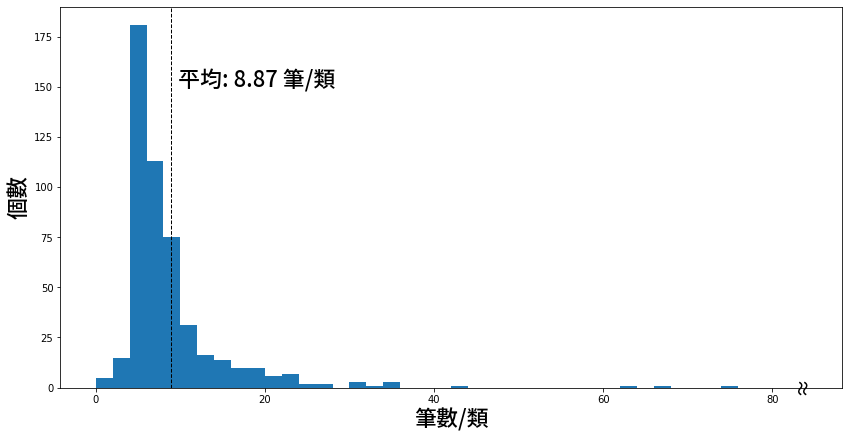

In [0]:
bins1 = np.append(np.arange(0, 20, 2), np.arange(20, 50, 2))
bins1 = np.append(bins1, np.arange(50, 85, 2))
#bins1 = np.append(bins1, [170])
plot_dist_class(counts, bins1)
plt.text(counts.mean() * 1.1, 150, '平均: {:.2f} 筆/類'.format(counts.mean()), fontproperties=fontprop)
plt.text(82.5, -1.5, '～', rotation=90, fontproperties=fontprop1)
plt.text(83, -1.5, '～', rotation=90, fontproperties=fontprop1)
plt.show()

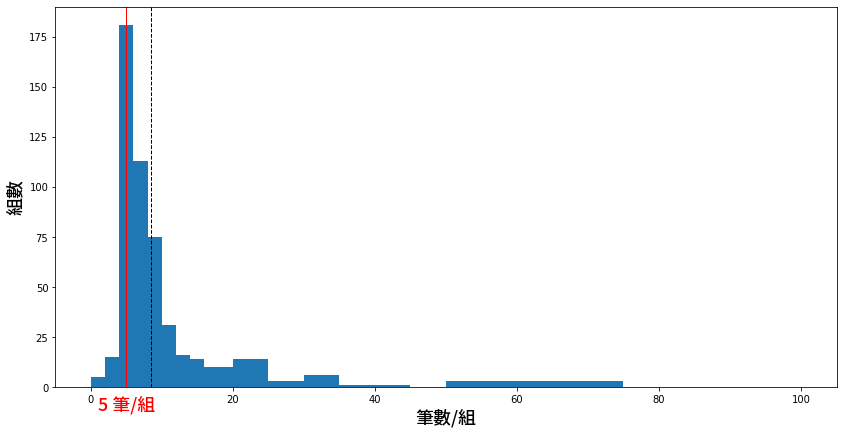

In [0]:
bins2 = np.append(np.arange(0, 20, 2), np.arange(20, 50, 5))
bins2 = np.append(bins2, np.arange(50, 105, 25))
plot_dist_class(counts[1:], bins2)
plt.axvline(5, color='r', linestyle='-', linewidth=1)
plt.text(1, -12, '5 筆/組', color='r', fontproperties=fontprop)
plt.show()

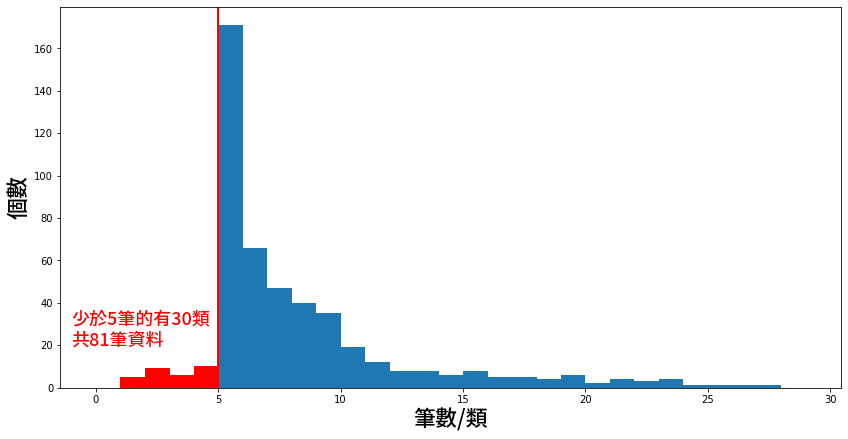

In [0]:
bins3 = np.arange(0, 30, 1)
plt.figure(figsize=(14, 7), facecolor="w")
n, bins, patches = plt.hist(counts, bins=bins3, histtype='bar')
plt.xlabel("筆數/類", fontproperties=fontprop)
#plt.ylabel("組數", fontproperties=fontprop, rotation = 0, labelpad=30)
plt.ylabel("個數", fontproperties=fontprop)
for i in range(5):
    patches[i].set_color('r')
#min_ylim, max_ylim = plt.ylim()

plt.axvline(5, color='r', linestyle='-', linewidth=2)
fontprop16 = fm.FontProperties(fname='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', size= 18)
plt.text(-1, 20, '少於5筆的有{}類\n共{}筆資料'.format(sum(counts < 5), sum(counts[counts < 5])),  fontproperties=fontprop16, color = 'r')
plt.show()

In [0]:
sum(counts）

SyntaxError: ignored